In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '../')

# import standard libraries
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import gust

# import embedding methods
from embedding.bernoulli import Bernoulli

# import utils
from utils import graph_util

# visualization
%matplotlib inline
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

In [2]:
# load data
A, y = graph_util.load_dataset()

In [3]:
# learn Bernoulli baseline model
b = Bernoulli(embedding_dimension=64, distance_meassure='sigmoid')
emb = b.learn_embedding(A)

np.save('ber_embedding.npy',emb)

Epoch    0, loss = 1.03373
Epoch  250, loss = 0.01136
Epoch  500, loss = 0.00461
Epoch  750, loss = 0.00282
Epoch 1000, loss = 0.00210
Epoch 1250, loss = 0.00170
Epoch 1500, loss = 0.00146
Epoch 1750, loss = 0.00129
Epoch 2000, loss = 0.00116
Epoch 2250, loss = 0.00107
Epoch 2500, loss = 0.00099
Epoch 2750, loss = 0.00092
Epoch 3000, loss = 0.00087
Epoch 3250, loss = 0.00082
Epoch 3500, loss = 0.00077
Epoch 3750, loss = 0.00073
Epoch 4000, loss = 0.00070
Epoch 4250, loss = 0.00067
Epoch 4500, loss = 0.00064
Epoch 4750, loss = 0.00061


In [4]:
# load node embeddings
emb = np.load('ber_embedding.npy')

print(f'Shape of adjacency matrix: {A.shape}')
print(f'Shape of embedding matrix: {emb.shape}')

Shape of adjacency matrix: (2485, 2485)
Shape of embedding matrix: (2485, 64)


In [5]:
## Evaluation ##
# Link prediction
# split the data into train, validation and test data
train_ones, val_ones, val_zeros, test_ones, test_zeros = gust.train_val_test_split_adjacency(A, p_val=0.10, p_test=0.05, random_state=0, neg_mul=1,
                                   every_node=True, connected=False, undirected=True,
                                   use_edge_cover=True, set_ops=True, asserts=False)


def create_edge_embedding(emb1, emb2, method="average"):
    if method=="average":
        return (emb1+emb2)/2

    
    
train_zeros = []
while len(train_zeros) < len(train_ones):
    i, j = np.random.randint(0, emb.shape[0]-1, 2)
    if A[i, j] == 0 and (i, j) not in train_zeros:
        train_zeros.append((i, j))
train_zeros = np.array(train_zeros)      

# Create edge embeddings for train_ones, train_zeros, test_ones, test_zeros
train_X = []
train_y = []

for nodes in train_ones:
    node_emb1 = emb[nodes[0]]
    node_emb2 = emb[nodes[1]]
    edge_emb_one = create_edge_embedding(node_emb1, node_emb2, method="average")
    train_X.append(edge_emb_one)
    train_y.append(1)

for nodes in train_zeros:
    node_emb1 = emb[nodes[0]]
    node_emb2 = emb[nodes[1]]
    edge_emb_one = create_edge_embedding(node_emb1, node_emb2, method="average")
    train_X.append(edge_emb_one)
    train_y.append(0)

    
test_X = []
test_y = []

for nodes in test_ones:
    node_emb1 = emb[nodes[0]]
    node_emb2 = emb[nodes[1]]
    edge_emb_one = create_edge_embedding(node_emb1, node_emb2, method="average")
    test_X.append(edge_emb_one)
    test_y.append(1)
    
for nodes in test_zeros:
    node_emb1 = emb[nodes[0]]
    node_emb2 = emb[nodes[1]]
    edge_emb_zero = create_edge_embedding(node_emb1, node_emb2, method="average")
    test_X.append(edge_emb_zero)
    test_y.append(0)
    
    
# Create train tuples (edge embedding, label) and test tuples (edge embedding, label)
train_X = np.array(train_X)
train_y = np.array(train_y)
test_X = np.array(test_X)
test_y = np.array(test_y)

print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(17232, 64)
(17232,)
(1016, 64)
(1016,)


In [6]:
# Train logistic regression
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression()
lg.fit(train_X, train_y)
score = lg.score(test_X, test_y)
print(f'Accuracy : {score}')


# Train random forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(train_X, train_y)
score = rf.score(test_X, test_y)
print(f'Accuracy : {score}')

Accuracy : 0.59251968503937
Accuracy : 0.8877952755905512


In [7]:
from sklearn.manifold import TSNE

def visualize(emb, y):
#     emb = emb.cpu().detach().numpy()
    tsne = TSNE()
    vis = tsne.fit_transform(emb)
    plt.figure(figsize=[10, 8])
    plt.scatter(vis[:, 0], vis[:, 1], c=palette[y], s=20, alpha=0.8)
    
# Alternative to the default seaborn palette
palette = np.array(sns.color_palette('muted', n_colors=len(np.unique(y))))

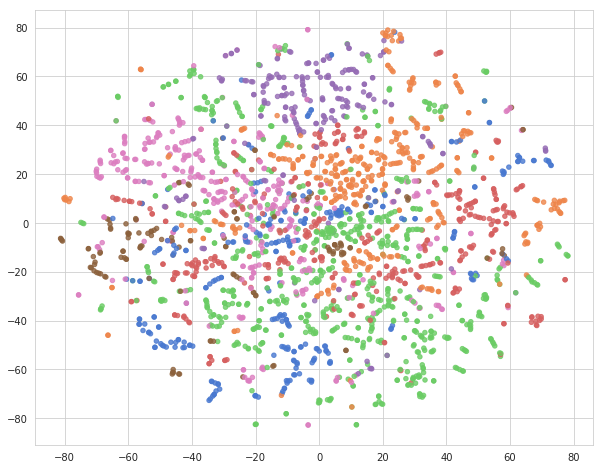

In [8]:
visualize(emb, y)